# Instructions
Run the cells in sequential order 

The data link to dataset - https://www.kaggle.com/datasets/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

The Taylor Swift Song Lyrics dataset on Kaggle is a collection of song lyrics from all of Taylor Swift's albums, including her debut album released in 2006 up to her latest album at the time of the dataset creation. The dataset includes lyrics from all of the songs on each album, including deluxe editions and bonus tracks. The dataset is provided in CSV format and includes columns for the album, song name, lyrics, and the year of release. It is intended to be used for natural language processing tasks, such as training language models or sentiment analysis, or for exploring patterns and trends in Taylor Swift's songwriting over time.

Here, we train a trigram model using Bayes Theorem. We create a probabilty table for every trigram token and generated lyrics.

Steps performed -

1) Dataset parsing

2) Tokenization, removal of special charactors, <s> </s> addition, /n addition

3) Tirgram creation 

4) Probabilty calculation - training

5) Generation

6) Perplexity calculation

## To get started
Download the dataset and put it in Dataset/taylorswift folder.

Run the cells

----------------------------------------
Contributed by - Rajat Keshri

# Import Libraries

In [3]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words('english')
sns.set_palette(sns.color_palette('tab20', 20))    

# Define the Langauge model class

In [60]:
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

class LanguageModel_NGram:
    # constants to define pseudo-word tokens
    # access via self.UNK, for instance
    UNK = "<UNK>"
    SENT_BEGIN = "<s>"
    SENT_END = "</s>"

    def __init__(self, n_gram=2, is_laplace_smoothing=1):
        """Initializes an untrained LanguageModel
        Parameters:
          n_gram (int): the n-gram order of the language model to create
          is_laplace_smoothing (bool): whether or not to use Laplace smoothing
        """
        self.n_gram = n_gram
        self.is_laplace = is_laplace_smoothing
        
        self.data = []
        self.lyric_dic = {}
        self.corpus = []
        self.lyric_dic_updated = {}
        self.lyric_dic_processed = {}
        self.token_count_dic = {}
        self.ngram_token_count_dict = {}
        self.total_tokens = 0
        self.total_vocab = 0
        self.unk_words = []
        
        self.prob_dic = {}
        self.ngram_tokenized_words = []
        self.unique_tokens_to_count_previous_dic = {}
        # -------------------------------------------
        
        
    def load_dataset(self, link_to_dataset):
        """Load the dataset into class variable
        Parameters:
          link_to_dataset: the path where the dataset is present
        """
        # Dataset loading
        self.data = pd.read_csv(link_to_dataset, encoding='windows-1252')
        print(self.data.head(20))
    
    def dataset_cleaning(self):
        """cleaning the data and making it usefull for the model
        Apply processing, adding to <s> </s> and /n to last words of every sentence
        """
        # Parsing dataset and organising
        lyric_dic = {} # song name to lyrics
        corpus = []
        data = self.data
        prev = data["track_title"][0] 
        temp = []
        
        for index, rows in data.iterrows():
            corpus.append(rows["lyric"])
            if prev == rows["track_title"]:
                temp.append(rows["lyric"])
            else:
                lyric_dic[prev] = temp
                prev = rows["track_title"]
                temp = []
                temp.append(rows["lyric"])
        self.lyric_dic = lyric_dic
        self.corpus = corpus
        #print(lyric_dic.keys())
        #print(corpus)
        
        lyric_dic_updated = {}
        for song in lyric_dic:
            t_songs = []
            for lyrics in lyric_dic[song]:
                t_words = []
                t_songs.append(self.preprocess_text(lyrics))
            lyric_dic_updated[song] = t_songs
        self.lyric_dic_updated = lyric_dic_updated
        #print(lyric_dic_updated)

        # Adding /n to the end word in each sentence to differentiate sentence ending
        lyric_dic_processed = {}
        for song_name in lyric_dic_updated:
            temp_array = []
            for n in range(0,self.n_gram):
                temp_array.append("<s>")
            
            for sentence in lyric_dic_updated[song_name]:
                temp = sentence.split(" ")
                temp[-1] = temp[-1] + "/n"
                merge = ""
                for w in temp:
                    merge += w + " "
                temp_array.append(merge[:len(merge)-1])
            
            for n in range(0,self.n_gram):
                temp_array.append("</s>")
            lyric_dic_processed[song_name] = temp_array
        self.lyric_dic_processed = lyric_dic_processed
        #print(lyric_dic_processed)
        n_items = take(1, lyric_dic_processed.items())
        print(n_items)
        
    def dataset_preprocess(self):
        """
        Generate the token count frequency dictionary
        """
        token_count_dic = {}
        count = 0
        for song_name in self.lyric_dic_updated:
            for sentence in self.lyric_dic_updated[song_name]:
                for word in sentence.split(" "):
                    if word not in token_count_dic:
                        token_count_dic[word]=1
                    else:
                        token_count_dic[word]+=1
                    count += 1
        self.total_tokens = count
        self.token_count_dic = token_count_dic
        #print(token_count_dic)
        
    def display_wordcloud(self):
        """
        Generate and display the word cloud
        """
        text = ""
        text += " ".join(self.corpus)+" "
        wordcloud = WordCloud().generate(text)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
    def display_stats_overall(self):
        """
        Display Dataset Stats
        """
        # Under standing the dataset - 
        # Plot the entire dataset yearwise to see the distribution
        data = self.data
        lyric_dic = self.lyric_dic
        corpus = self.corpus
        
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        y1 = data[data['year'] == 2017]['lyric'].str.len()
        sns.distplot(y1, label='2017')
        y2 = data[data['year'] == 2014]['lyric'].str.len()
        sns.distplot(y2, label='2014')
        y3 = data[data['year'] == 2012]['lyric'].str.len()
        sns.distplot(y3, label='2012')
        y4 = data[data['year'] == 2010]['lyric'].str.len()
        sns.distplot(y4, label='2010')
        y5 = data[data['year'] == 2008]['lyric'].str.len()
        sns.distplot(y5, label='2008')
        y6 = data[data['year'] == 2006]['lyric'].str.len()
        sns.distplot(y6, label='2006')
        plt.title('Year Wise - Lyrics Length Distribution')
        plt.legend();
        
    def display_stats_before(self):
        """
        Display dataset information before preprocessing
        """
        print("Dataset Information before preprocessing")
        corpus = self.corpus
        
        # number of songs
        num_of_songs = len(self.lyric_dic)
        print("Number of songs = ", num_of_songs)

        # Vocab size
        vocab_size = 0
        vocab = []
        for sentence in corpus:
            vocab_size += len(set(sentence.split(" ")))
            vocab += list(set(sentence.split(" ")))
        print("Vocab size = ", vocab_size)

        # Token size
        token_size = 0
        tokens = []
        for sentence in corpus:
            token_size += len(sentence.split(" "))
            tokens += sentence.split(" ")
        print("Token size = ", token_size)

        # word count
        print("Word Count (Displaying counts greater than 100 for visualization)")
        word_count = {}
        for sentence in corpus:
            for word in sentence.split(" "):
                if word not in word_count.keys():
                    word_count[word] = 1
                else:
                    word_count[word] += 1
        word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
        word_count = dict(word_count)

        word_count_cutoff = {}
        for i in word_count:
            if word_count[i] > 50:
                word_count_cutoff[i] = word_count[i]
        names = list(word_count_cutoff.keys())
        values = list(word_count_cutoff.values())
        plt.bar(range(len(word_count_cutoff)), values, tick_label=names)
        plt.tick_params(width=5)
        plt.ylabel("Count")
        plt.xticks(rotation = -45)
        plt.show()
        #print(word_count_cutoff)
        
        print("Dataset")
        #print(self.lyric_dic)
        n_items = take(1, self.lyric_dic.items())
        print(n_items)
    
    def train(self):
        """Trains the language model on the given data. Assumes that the given data
        has tokens that are white-space separated, has one sentence per line, and
        that the sentences begin with <s> and end with </s>
        """

        # -----------------------------------------------------------
        # unique words/tokens in the corpus
        self.total_unique_tokens = len(self.token_count_dic)
        #print(self.total_unique_tokens)
        
        # -----------------------------------------------------------
        # replace with UNK for freq==1
        for token in self.token_count_dic:
            if self.token_count_dic[token] == 1:
                self.unk_words.append(token)
        
        all_sentences = []
        for song_name in self.lyric_dic_processed:
            t = ""
            for s in self.lyric_dic_processed[song_name]:
                t += s + " "
            all_sentences.append(t)
        #print(all_sentences)
        
        # -----------------------------------------------------------
        # split all sentences in n-gram sequences of array - tokenization
        self.ngram_tokenized_words = self.ngram_tokenization(all_sentences)
        #print(self.ngram_tokenized_words)    
        
        # -----------------------------------------------------------
        # count occurrences of each token and store it in a dictionary
        self.ngram_token_count_dict = self.count_all_token_freq(self.ngram_tokenized_words)
        #print(self.ngram_token_count_dict)
        
        # -----------------------------------------------------------
        # count total number of occurrences of each ngram token for previous words (ngram - 1)
        self.unique_tokens_to_count_previous_dic = self.count_unique_tokens(all_sentences)
        #print(self.unique_tokens_to_count_previous_dic)
        
        # -----------------------------------------------------------
        # calculate probability of each token
        # save the model in a variable - save the counts and the probabilities
        if self.n_gram == 1:
            for token in self.ngram_tokenized_words:
                temp_tuple = tuple(token)
                if self.is_laplace == 1:
                    self.total_unique_tokens = len(self.ngram_token_count_dict.keys())
                    self.prob_dic[temp_tuple] = (self.ngram_token_count_dict[temp_tuple] + 1) / \
                                                (self.total_tokens + self.total_unique_tokens)
                else:
                    self.prob_dic[temp_tuple] = self.ngram_token_count_dict[
                                                    temp_tuple] / self.total_tokens

        else:
            for token in self.ngram_tokenized_words:
                temp_tuple = tuple(token)
                temp_tuple_denominator = tuple(token[:len(token) - 1])
                if self.is_laplace == 1:
                    self.prob_dic[temp_tuple] = (self.ngram_token_count_dict[temp_tuple] + 1) / \
                                                (self.unique_tokens_to_count_previous_dic[
                                                     temp_tuple_denominator]
                                                 + self.total_unique_tokens)
                else:
                    self.prob_dic[temp_tuple] = self.ngram_token_count_dict[temp_tuple] / \
                                                self.unique_tokens_to_count_previous_dic[
                                                    temp_tuple_denominator]
        print("Training completed, Prob generated (random 20)")
        #print(self.prob_dic)
        n_items = take(20, self.prob_dic.items())
        print(n_items)
        
    def score(self, sentence):
        """Calculates the probability score for a given string representing a single sentence.
        Parameters:
          sentence (str): a sentence with tokens separated by whitespace to calculate the score of

        Returns:
          float: the probability value of the given string for this model
        """

        # replace with UNK for words not in corpus
        sentence_updated = ""
        for word in sentence.split():
            if word not in self.token_count_dic:
                sentence_updated += self.UNK + " "
            else:
                sentence_updated += word + " "

        # tokenize the input sentence based on ngrams
        ngram_tokenized_words = self.ngram_tokenization([sentence_updated])
        # print(tokenized_words)

        score = 1
        for token in ngram_tokenized_words:
            if self.is_laplace:
                temp_tuple_denominator = temp_tuple_denominator = tuple(token[:len(token) - 1])
                if token not in self.prob_dic and temp_tuple_denominator in \
                        self.unique_tokens_to_count_previous_dic:
                    score *= 1 / (self.unique_tokens_to_count_previous_dic[temp_tuple_denominator]
                                  + self.total_unique_tokens)
                elif token not in self.prob_dic and temp_tuple_denominator not in \
                        self.unique_tokens_to_count_previous_dic:
                    score *= 1 / self.total_unique_tokens
                else:
                    score *= self.prob_dic[token]
            else:
                if token not in self.prob_dic:
                    score *= 0
                else:
                    score *= self.prob_dic[token]

        return score

    def generate_sentence(self):
        """Generates a single sentence from a trained language model using the Shannon technique.

        Returns:
          str: the generated sentence
        """
        sentence = ""
        for n in range(self.n_gram - 1):
            sentence += self.SENT_BEGIN + " "
        start = sentence

        sorted_prob_dic = dict(sorted(self.prob_dic.items(), key=lambda x: x[1], reverse=True))
        max_prob = sorted_prob_dic[list(sorted_prob_dic.keys())[0]]
        avg_prob = (sorted_prob_dic[list(sorted_prob_dic.keys())[0]]
                    + sorted_prob_dic[list(sorted_prob_dic.keys())[-1]]) / 2
        final_sentence = ""

        if self.n_gram == 1:
            while 1:
                r = random.uniform(0, avg_prob / self.n_gram)
                all_match = []
                for token in sorted_prob_dic.keys():
                    if sorted_prob_dic[token] > r / 2 and token[-1] != self.SENT_BEGIN:
                        all_match.append(token)

                token = random.choice(all_match)
                final_sentence += token[-1] + " "

                if self.SENT_END in final_sentence:
                    final_sentence = self.SENT_BEGIN + " " + final_sentence
                    break

        else:
            while 1:
                all_match = []
                for token in sorted_prob_dic.keys():
                    sentence_temp = tuple(sentence.split())
                    if sentence_temp == token[:self.n_gram - 1]:
                        all_match.append(token)

                if len(all_match) == 0:
                    print("dataset is not formatted for ", self.n_gram)
                    break
                token = random.choice(all_match)
                # for token in all_match:
                sentence_temp = tuple(sentence.split())
                # if sentence_temp == token[:self.n_gram-1]:
                final_sentence += token[-1] + " "

                sentence = ""
                for w in list(sentence_temp[1:self.n_gram - 1]):
                    sentence += w + " "
                sentence += token[-1]

                if self.SENT_END in final_sentence:
                    break

            final_sentence = start + final_sentence + self.SENT_END * (self.n_gram - 2)
        return final_sentence

    def generate(self, n):
        """Generates n sentences from a trained language model using the Shannon technique.
        Parameters:
          n (int): the number of sentences to generate

        Returns:
          list: a list containing strings, one per generated sentence
        """
        all_sentences = []
        for i in range(0, n):
            all_sentences.append(self.generate_sentence())
        return all_sentences

    def perplexity(self, test_sequence):
        """
        Measures the perplexity for the given test sequence with this trained model.
        As described in the text, you may assume that this sequence may consist of many sentences
        "glued together".

        Parameters:
          test_sequence (string): a sequence of space-separated tokens to measure the perplexity of
        Returns:
          float: the perplexity of the given sequence
        """

        score = self.score(test_sequence)
        if score == 0:
            return 0
        else:
            return math.sqrt(1 / score)

    # -----------------------------------------
    # helpers
    def preprocess_text(self, text):
        """
        Preprocess the text - remove punctuation, stopwords 
        Params:
            Text to preprocess
        return:
            Preprocessed text
        """
        # lower case
        preprocessed = text.lower()

        # punctuation removal
        def remove_punctuation(text):
            punctuationfree="".join([i for i in text if i not in string.punctuation])
            return punctuationfree
        preprocessed = remove_punctuation(preprocessed)

        # stop work removal
        def remove_stopwords(text):
            text = text.split()
            output= [i for i in text if i not in stopwords]
            final = ""
            for i in output:
                final+=i + " "
            return final[:len(final)-2]
        #preprocessed = remove_stopwords(preprocessed)
        return preprocessed
    
    def ngram_tokenization(self, sentences):
        """
        :param 
            sentences: all sentences in an array
        :return: 
            returns all tokens based on ngrams
        """
        n_gram = self.n_gram

        tokens = []
        for sentence in sentences:
            sen = sentence.split()
            for t in range(0, len(sen) - n_gram + 1):
                tokens.append(tuple(sen[t:t + n_gram]))

        return tokens

    def count_all_token_freq(self, tokenized_words):
        """
        :return: 
            token to count frequency
        """
        d = {}
        for token in tokenized_words:
            temp_tuple = tuple(token)
            if temp_tuple not in d:
                d[temp_tuple] = 1
            else:
                d[temp_tuple] += 1
        return d
    
    def count_unique_tokens(self, sentences_from_file):
        """
        find count of each token present. The tokens are created based on ngrams
        :param sentences_from_file: sentences array
        :return: token tuples to count dictionary (depends on ngram - 1)
        """
        word_d = {}
        n_gram = self.n_gram

        for sen in sentences_from_file:
            sen = sen.split()
            for t in range(0, len(sen) - n_gram + 1):
                if n_gram == 1:
                    if tuple(sen[t:t + n_gram]) not in word_d:
                        word_d[tuple(sen[t:t + n_gram])] = 1
                    else:
                        word_d[tuple(sen[t:t + n_gram])] += 1
                else:
                    if tuple(sen[t:t + n_gram - 1]) not in word_d:
                        word_d[tuple(sen[t:t + n_gram - 1])] = 1
                    else:
                        word_d[tuple(sen[t:t + n_gram - 1])] += 1
        return word_d
    

# Define the language model

## Load the model and the dataset

In [61]:
# load model
model = LanguageModel_NGram(n_gram=3)

# load dataset
model.load_dataset("Dataset/taylorswift/train.csv")

          artist         album track_title  track_n  \
0   Taylor Swift  Taylor Swift  Tim McGraw        1   
1   Taylor Swift  Taylor Swift  Tim McGraw        1   
2   Taylor Swift  Taylor Swift  Tim McGraw        1   
3   Taylor Swift  Taylor Swift  Tim McGraw        1   
4   Taylor Swift  Taylor Swift  Tim McGraw        1   
5   Taylor Swift  Taylor Swift  Tim McGraw        1   
6   Taylor Swift  Taylor Swift  Tim McGraw        1   
7   Taylor Swift  Taylor Swift  Tim McGraw        1   
8   Taylor Swift  Taylor Swift  Tim McGraw        1   
9   Taylor Swift  Taylor Swift  Tim McGraw        1   
10  Taylor Swift  Taylor Swift  Tim McGraw        1   
11  Taylor Swift  Taylor Swift  Tim McGraw        1   
12  Taylor Swift  Taylor Swift  Tim McGraw        1   
13  Taylor Swift  Taylor Swift  Tim McGraw        1   
14  Taylor Swift  Taylor Swift  Tim McGraw        1   
15  Taylor Swift  Taylor Swift  Tim McGraw        1   
16  Taylor Swift  Taylor Swift  Tim McGraw        1   
17  Taylor

## Apply dataset cleaning and preprocessing

In [62]:
# applying cleaning of dataset
model.dataset_cleaning()

# apply preprocessing dataset
model.dataset_preprocess()

[('Tim McGraw', ['<s>', '<s>', '<s>', 'he said the way my blue eyes shined/n', 'put those georgia stars to shame that night/n', 'i said thats a lie/n', 'just a boy in a chevy truck/n', 'that had a tendency of gettin stuck/n', 'on backroads at night/n', 'and i was right there beside him all summer long/n', 'and then the time we woke up to find that summer gone/n', 'but when you think tim mcgraw/n', 'i hope you think my favorite song/n', 'the one we danced to all night long/n', 'the moon like a spotlight on the lake/n', 'when you think happiness/n', 'i hope you think that little black dress/n', 'think of my head on your chest/n', 'and my old faded blue jeans/n', 'when you think tim mcgraw/n', 'i hope you think of me/n', 'september saw a month of tears/n', 'and thankin god that you werent here/n', 'to see me like that/n', 'but in a box beneath my bed/n', 'is a letter that you never read/n', 'from three summers back/n', 'its hard not to find it all a little bittersweet/n', 'and lookin back

## Display Stats of dataset 

C:\Users\rajat\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rajat\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rajat\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

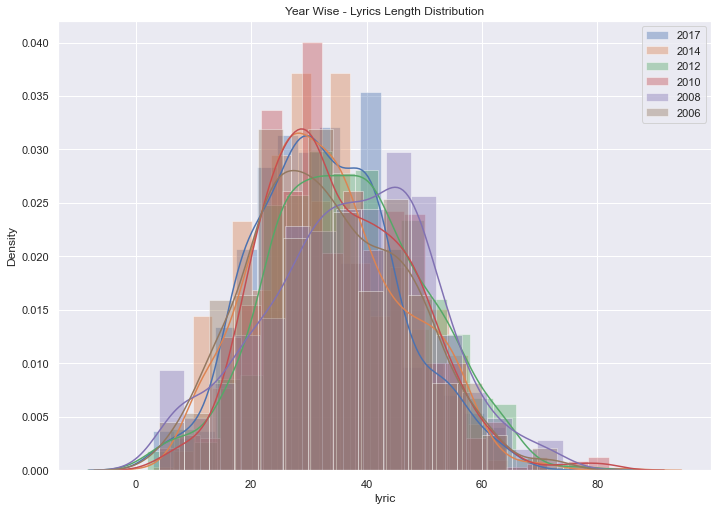

In [63]:
# display model stats
model.display_stats_overall()

Dataset Information before preprocessing
Number of songs =  90
Vocab size =  32373
Token size =  33976
Word Count (Displaying counts greater than 100 for visualization)


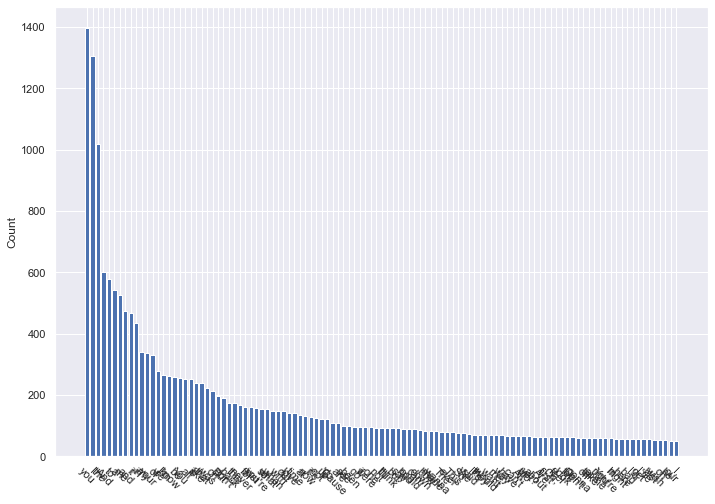

Dataset
[('Tim McGraw', ['He said the way my blue eyes shined', 'Put those Georgia stars to shame that night', 'I said, "That\'s a lie"', 'Just a boy in a Chevy truck', "That had a tendency of gettin' stuck", 'On backroads at night', 'And I was right there beside him all summer long', 'And then the time we woke up to find that summer gone', 'But when you think Tim McGraw', 'I hope you think my favorite song', 'The one we danced to all night long', 'The moon like a spotlight on the lake', 'When you think happiness', 'I hope you think that little black dress', 'Think of my head on your chest', 'And my old faded blue jeans', 'When you think Tim McGraw', 'I hope you think of me', 'September saw a month of tears', "And thankin' God that you weren't here", 'To see me like that', 'But in a box beneath my bed', 'Is a letter that you never read', 'From three summers back', "It's hard not to find it all a little bittersweet", "And lookin' back on all of that, it's nice to believe", 'When you thi

In [64]:
# display stats of model before preprocessing
model.display_stats_before()

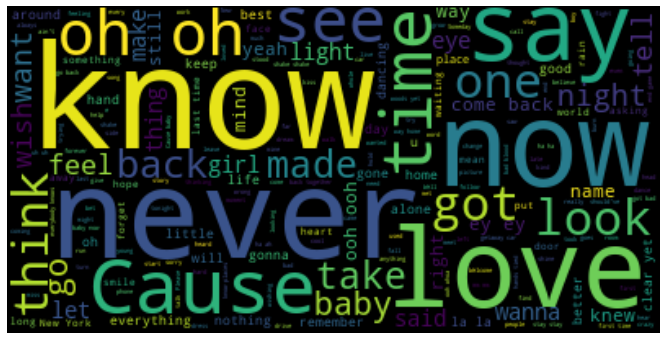

In [65]:
# dispplay wordcloud
model.display_wordcloud()

# Training the Model

In [66]:
# traing the model to create prob table for trigrams
model.train()

Training completed, Prob generated (random 20)
[(('<s>', '<s>', '<s>'), 0.036312849162011177), (('<s>', '<s>', 'he'), 0.0015961691939345571), (('<s>', 'he', 'said'), 0.0012881064834693002), (('he', 'said', 'the'), 0.0012858979854264896), (('said', 'the', 'way'), 0.0012881064834693002), (('the', 'way', 'my'), 0.001271725307333616), (('way', 'my', 'blue'), 0.001288659793814433), (('my', 'blue', 'eyes'), 0.001288659793814433), (('blue', 'eyes', 'shined/n'), 0.0008587376556462001), (('eyes', 'shined/n', 'put'), 0.0008594757198109154), (('shined/n', 'put', 'those'), 0.0008594757198109154), (('put', 'those', 'georgia'), 0.001288659793814433), (('those', 'georgia', 'stars'), 0.001288659793814433), (('georgia', 'stars', 'to'), 0.001288659793814433), (('stars', 'to', 'shame'), 0.001288659793814433), (('to', 'shame', 'that'), 0.001288659793814433), (('shame', 'that', 'night/n'), 0.001288659793814433), (('that', 'night/n', 'i'), 0.001287001287001287), (('night/n', 'i', 'said'), 0.0012881064834693

## Sentence generation

In [67]:
# generate random sentences
sentence = model.generate_sentence()
sentence_split = sentence.split(" ")
t = ""
generated_song = []
for word in sentence_split:
    if "<s>" in word or "</s>" in word:
        pass
    elif "/n" in word:
        t += word[:len(word)-2]
        generated_song.append(t)
        t = ""
    else:
        t += word + " "
    
for s in generated_song:
    print(s)

one look dark room meant just for me and you
not before i locked you out
but i cried cried for you
died for you
and i want ill never be alone
iisland breeze and lights down low
no one in the clear yet in the clear yet
are we pretending this is wishful thinking
probably mindless dreaming
but if god forbid fate should step in
and well sing hallelujah
oh oh
so weve been outnumbered raided and now i see now i just know
youre really gonna be alright
cause the players gonna play play play
and the camera flashes make it look like me
you say its been a while since she brought you in
and you just feel used
and all i really know
i just lost a friend
hope you couldnt take the heat
i walked through the free fall
like the radio
he whispers songs into my window
in words that you speak
and any snide remarks from my neck
the night when we go crashing down we come back every time
cause i read you like its a revolution throw your head back laughing like a firework show
drop everything now
meet me there 

## Perplexity and Score 

In [69]:
# load test data
test_data = pd.read_csv("Dataset/taylorswift/test.csv", encoding='windows-1252')
#print(test_data)

# Parsing dataset and organising
lyric_dic = {} # song name to lyrics
corpus = []
data = test_data
prev = data["track_title"][0] 
all_sentences = []

temp = []
for index, rows in data.iterrows():
    corpus.append(rows["lyric"])
    if prev == rows["track_title"]:
        temp.append(rows["lyric"])
    else:
        lyric_dic[prev] = temp
        prev = rows["track_title"]
        temp = []
        temp.append(rows["lyric"])

lyric_dic_updated = {}
for song in lyric_dic:
    t_songs = []
    for lyrics in lyric_dic[song]:
        t_words = []
        t_songs.append(model.preprocess_text(lyrics))
    lyric_dic_updated[song] = t_songs
#print(lyric_dic_updated)

for song_name in lyric_dic_updated:
    for sen in lyric_dic_updated[song_name]:
        all_sentences.append(sen)
#print(all_sentences)
        
# pick random sentences (10 sentences)
for i in range(0,10):
    random_sentence = random.choice(all_sentences)
    print(random_sentence)
    
    # score and perplexity
    score = model.score(random_sentence)
    print("Score ", score)
    
    perplexity = model.perplexity(random_sentence)
    print("Perplexity ", perplexity)
    print()


not because he owns me
Score  7.94640816715252e-11
Perplexity  112179.77525383084

and heres to my baby
Score  1.5757070620270734e-10
Perplexity  79664.02757832421

all the liars are calling me one
Score  1.4342040210431505e-17
Perplexity  264055083.0798465

feeling so gatsby for that whole year
Score  1.4662397765939778e-17
Perplexity  261154492.69732276

it was so nice throwing big parties
Score  1.445152525623046e-17
Perplexity  263052938.0952816

holdin my breath slowly i said
Score  3.4148724396873745e-14
Perplexity  5411438.875026863

call it what you want call it what you want call it
Score  1.803362614873349e-33
Perplexity  2.3548240840035588e+16

i had to take them away
Score  9.95123174350077e-14
Perplexity  3170016.917359275

and there are no rules when you show up here
Score  1.1372652634088794e-27
Perplexity  29653032451452.54

i had to take them away
Score  9.95123174350077e-14
Perplexity  3170016.917359275



In [70]:
# BLEU score
song = lyric_dic_updated["This Is Why We Can't Have Nice Things"]

given_song = ""
for s in song:
    given_song += s + " "
given_song = given_song.split(" ")
#print(given_song)

gen_song = ""
for s in generated_song:
    gen_song += s + " "
gen_song = gen_song.split(" ")
#print(gen_song)

from nltk.translate.bleu_score import sentence_bleu
score = sentence_bleu(given_song, gen_song)
print(score)

6.587480718373388e-232


C:\Users\rajat\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\rajat\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\rajat\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

In [71]:
#model.ngram_tokenized_words

In [72]:
#model.prob_dic